# Intraprediction Project



## ENCODER DECODER



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
import random
import sys
import os
from optparse import OptionParser
import numpy as np
from torch import optim
from PIL import Image
from torch.autograd import Function, Variable
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset
import cv2
import glob
import pickle
from tqdm import tqdm
%matplotlib inline

### [ TODO 1 ] First define following layers to be used later
- **Conv2d + BatchNorm2d + ReLu ** as **single conv2d layer** ,
- **Maxpool2d + single conv2d layer ** as **down layer**,
- **Upsample + single conv2d layer ** as **up layer** ,
-  **Conv2d ** as **outconv layer** 

You can check out the documentation in this link to understand how to use the methods called in the provided template:

 https://pytorch.org/docs/stable/nn.html
 
  ![single_conv](single_conv_layer.png)
  ![down_layer](down_layer.png)
  ![up_layer](Up_layer.png)
  ![outconv_layer](outconv_layer.png)
  

In [2]:
################################################ [TODO] ###################################################
# DEFINE SINGLE_CONV CLASS
class single_conv(nn.Module):
    '''(conv => BN => ReLU) '''
    def __init__(self, in_ch, out_ch):
        super(single_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.BatchNorm2d(in_ch), # Channels in
            nn.Conv2d(in_ch,out_ch,3,padding = (1,1)), #(channel in, channel out, filter)
            nn.Tanh(), #Channel in
        )

    def forward(self, x):
        #paddings = tf.constant([[0, 0,],[0, 0,],[1, 1,], [1, 1]])
        #x = tf.pad(x, paddings, "SYMMETRIC")
        x = self.conv(x)
        return x



################################################ [TODO] ###################################################
# DEFINE DOWN CLASS
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.down = nn.Conv2d(in_ch,in_ch,kernel_size=3,stride =2) #(channel in, channel out, filter)
        self.conv = single_conv(in_ch, out_ch) # use previously defined single_cov
    def forward(self, x):
        x = self.down(x)
        x = self.conv(x)
        return x
    

################################################ [TODO] ###################################################
# DEFINE UP CLASS
# Note that this class will not only upsample x1, but also concatenate up-sampled x1 with x2 to generate the final output

class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()       
        self.up = nn.Upsample(2,'bilinear') # use nn.Upsample( )
        self.conv = single_conv(in_ch,out_ch) # use previously defined single_cov

    def forward(self, x):
        # This part is tricky, so we provide it for you
        # First we upsample x1
        x = nn.functional.interpolate(x, size=None, scale_factor=2, mode='bilinear')
        x = self.conv(x)
        return x
    
class resize(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(resize, self).__init__()       
        self.up = nn.Upsample(2,'bilinear') # use nn.Upsample( )
        self.conv = nn.Sequential(
            nn.BatchNorm2d(in_ch), # Channels in
            nn.Conv2d(in_ch,out_ch,3), #(channel in, channel out, filter)
            nn.Tanh(), #Channel in
        )
    def forward(self, x, siz):
        x = nn.functional.interpolate(x, size=(siz+2,siz+2),  mode='bilinear')
        x = self.conv(x)
        return x

################################################ [TODO] ###################################################
# DEFINE OUTCONV CLASS
class quat(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(quat, self).__init__()
        self.down = down(in_ch,out_ch)
    def forward(self, x):
        x = self.down(x)
        #Quatization
        T = 1
        x = (x > T).float() * 1
        return x

class upT(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(upT, self).__init__()
        self.up =  nn.Sequential(
            nn.BatchNorm2d(in_ch), # Channels in
            nn.ConvTranspose2d(in_ch,out_ch,kernel_size=4, stride=2), #(channel in, channel out, filter)
            nn.Tanh(), #Channel in
        )
    def forward(self, x):
        x = self.up(x)
        return x

In [3]:
################################################ [TODO] ###################################################
# Build your network with predefined classes: single_conv, up, down, outconv
# The number of input and output channels should follow the U-Net Structure shown above.
import torch.nn.functional as F
class UNet(nn.Module):
    def __init__(self, n_channels):
        super(UNet, self).__init__()
        self.inc = single_conv(n_channels, 6) # conv2d +  batchnorm + relu 
        self.down1 = resize(6, 8)              # maxpool2d + conv2d + batchnorm + relu
        self.down2 = resize(8, 8)              # maxpool2d + conv2d + batchnorm + relu
        self.down3 = resize(8,8)                # maxpool2d + conv2d + batchnorm + relu +Quatization
        self.up1 = upT(8,6)                   # upsample + pad + conv2d + batchnorm + relu
        self.up2 = upT(6,3)             # conv2d
        self.upF =  nn.Sequential(nn.Conv2d(3,3,3), #(channel in, channel out, filter)
            nn.Tanh(), #Channel in
        )
        self.upF2 =  nn.Sequential(nn.Conv2d(8,8,2), #(channel in, channel out, filter)
            nn.Tanh(), #Channel in
        )
    def forward(self, x):
        #ENCODE
        x = self.inc(x) #16x16
        x = self.down1(x,12) #12x12
        x = self.down2(x,8) #8x8
        x = self.down3(x,4) #4x4
        x = self.upF2(x) #3x3
        #x = self.quat(x) 
        #DECODE
        x = self.up1(x) #8x8
        x = self.up2(x) #18x18
        #x = self.up3(x)
        x = self.upF(x) #16x16
        #x = x[:,:,8:24,8:24];
        return x    

### [ TODO 2 ] Define evaulation function:
Based on what we have learnt in class, Dice coefficient is defined as 
![dice.png](dice.png)
For the case of evaluating a Dice coefficient on predicted segmentation masks, we can approximate intersection of A and B as the element-wise multiplication between the prediction and target mask, and then sum the resulting matrix.

In order to quantify the area of A union B, some researchers use the simple sum whereas other researchers prefer to use the squared sum for this calculation. You can use either way.



In [4]:
################################################ [TODO] ###################################################
# define dice coefficient 
class MseCoeff(Function):
    """Dice coeff for one pair of input image and target image"""
    def forward(self, input, target):
        self.save_for_backward(input, target)
        ################################################ [TODO] ###################################################
        # Calculate intersection and union. 
        # You can convert the input image into a vector with input.contiguous().view(-1)
        # Then use torch.dot(A, B) to calculate the intersection.
        # Use torch.sum(A) to get the sum.
        input = input.contiguous().view(-1)
        target = target.contiguous().view(-1)
        # Calculate Mean Squared Error
        diff = input - target;
        dot =  torch.dot(diff,diff)
        dot = dot/input.numel()
        return dot


################################################ [TODO] ###################################################
# Calculate dice coefficients for batches
def mse_coeff(input, target):
    """Dice coeff for batches"""
    s = torch.FloatTensor(1).zero_()    
    # For each pair of input and target, call DiceCoeff().forward(input, target) to calculate dice coefficient
    # Then average
    MSE = MseCoeff()
    for i, (c, b) in enumerate(zip(input, target)):
        s += MSE.forward(c,b);
    s = s / (i + 1)
    return s

def grad(input):
    x_right = F.pad(input, (0, 1, 0, 0))
    x_left = F.pad(input, (1, 0, 0, 0 ))
    y_up =   F.pad(input, (0, 0, 1, 0 )) 
    y_down =   F.pad(input, (0, 0, 0,1))
    dx = x_right - x_left;
    dy = y_up - y_down;
    return dx[:,1:16, 1:16], dy[:,1:16, 1:16]

def grad_loss(input, target, epoch):
    s = torch.FloatTensor(1).zero_()    
    # For each pair of input and target, call DiceCoeff().forward(input, target) to calculate dice coefficient
    # Then average
   # print(input.shape)
   # print(target.shape)
    MSE = MseCoeff()
    s = 0;
    if epoch == 0:
        p,q,r = 0.8, 0.2, 0.2
    elif epoch == 1: 
        p,q,r  = 0.4, 0.6, 0.6
    else:
        p,q,r  = 0.4,0.6, 0.6
    for i, (c, b) in enumerate(zip(input, target)): 
        Gx_in , Gy_in = grad(c)
        Gx_target, Gy_target = grad(b)
        s += p*MSE.forward(c,b);
        s += q*MSE.forward(Gx_in,Gx_target);
        s += r*MSE.forward(Gy_in, Gy_target);
    s = s / (i+1)
    return s



### Load images and masks

Load training imagse, normalize and resize them into smaller size so that you can perform training using a CPU. Split them into training and validation. Validation percent of 0.05 means 5% of training dataset is used as validation. In order to avoid repeated data preprocessing, we use the pickle tool to save the processed data.

This part has been done for you. But please read through so that you learn the general processing steps.

In [5]:
validation = glob.glob('./Data/Validation/*')
train = glob.glob('./Data/Train/*')
test = glob.glob('./Data/Test/*')
valiDataset = []
trainDataset = []
testDataset = []
#Loads the following in a list of (3, 16,16) and (3, 20,20)
for i in range(len(validation)):
    f=open(validation[i],'rb')
    b=pickle.load(f)
    #flip the data dimension
    b = np.transpose(b, axes=[3, 2, 0, 1]) 
    f.close()
    valiDataset.append(b)
    
for i in range(len(test)):
    f=open(test[i],'rb')
    b=pickle.load(f)
    b = np.transpose(b, axes=[3, 2, 0, 1]) 
    f.close()
    testDataset.append(b)
    
for i in range(len(train)):
    f=open(train[i],'rb')
    b=pickle.load(f)
    b = np.transpose(b, axes=[3, 2, 0, 1]) 
    f.close()
    trainDataset.append(b)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


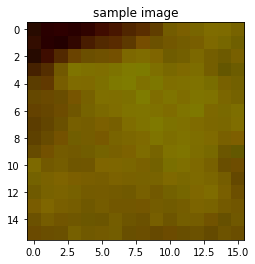

In [6]:
#### Let us display some of the images to make sure the data loading and processing is correct.
### the original size of the image is: 1280*1918, but we resize the image to 80*100 for 
### training the segmentation network
img_num = 90
a = trainDataset[0][img_num]
a = np.transpose(a, axes = [1,2,0])
plt.imshow(a)
plt.title("sample image")
plt.show()

### Create datasets in the format that you can later use Torch  "DataLoader" during training and define  data augmentation 

In [27]:
#### define transform classes for  data augmentation
class Flip(object):
    """
    Flip the image left or right for data augmentation, but prefer original image.
    """
    def __init__(self,ori_probability=0.60):
        self.ori_probability = ori_probability
 
    def __call__(self, sample):
        if random.uniform(0,1) < self.ori_probability:
            return sample
        else:
            img, label = sample['img'], sample['label']
            img_flip = img[:,:,::-1]
            label_flip = label[:,::-1]
            
            return {'img': img_flip, 'label': label_flip}
        
class ToTensor(object):
    """
    Convert ndarrays in sample to Tensors.
    """
    def __init__(self):
        pass

    def __call__(self, sample):
        image, label = sample['img'], sample['label']

        return {'img': torch.from_numpy(image.copy()).type(torch.FloatTensor),
                'label': torch.from_numpy(label.copy()).type(torch.FloatTensor)}

In [28]:
# the dataset class
class CustomDataset(Dataset):
    def __init__(self, images, image_masks,  transforms=None):   # initial logic happens like transform
        self.image = images
        self.image_masks = image_masks
        self.transforms = transforms
    
    def __len__(self):  # return count of sample we have

        return len(self.image_masks)
    
    def __getitem__(self, index):
        orig = self.image[index];
        image = self.image_masks[index]
        sample = {'img': orig, 'label': image}
        if transforms:
            sample = self.transforms(sample)            
        return sample

#train_dataset = CustomDataset(((trainDataset[1]-128)/255), trainDataset[0], transforms=transforms.Compose([Flip(),ToTensor()]))
train_dataset = CustomDataset(trainDataset[0], trainDataset[0], transforms=transforms.Compose([Flip(),ToTensor()]))
val_dataset = CustomDataset(valiDataset[0], valiDataset[0], transforms=transforms.Compose([Flip(),ToTensor()]))

### [ TODO 3 ] Start training your network

In [182]:
################################################ [TODO] ###################################################
# Create a UNET object. Input channels = 3, output channels = 1
net = UNet(3);

In [183]:
################################################ [TODO] ###################################################
# This function is used to evaluate the network after each epoch of training
# Input: network and validation dataset
# Output: average dice_coeff
def eval_net(net, dataset):
    # set net mode to evaluation
    net.eval()
    tot = 0
    for i, b in enumerate(dataset):
        img = b['img']
        label = b['label']
        img = img.type(torch.FloatTensor);
        ################################################ [TODO] ################################################### 
        # Feed in the image to get predicted mask
        pred_img = net.forward(img)
        tot += mse_coeff(pred_img,label);
    return tot / (i + 1)

In [184]:
################################################ [TODO] ###################################################
# Specify number of epochs, image scale factor, batch size and learning rate
epochs = 2

# i.e, 4
batch_size = 50 # i.e, 16
lr = 0.01        # i.e, 0.01
lr_lambda = lambda epoch: 0.95 ** epoch
N_train = len(train_dataset)
model_save_path = './model/'  # directory to same the model after each epoch. 


################################################ [TODO] ###################################################
# Define an optimizer for your model.
# Pytorch has built-in package called optim. Most commonly used methods are already supported.
# Here we use stochastic gradient descent to optimize
# For usage of SGD, you can read https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html
# Also you can use ADAM as the optimizer
# For usage of ADAM, you can read https://www.programcreek.com/python/example/92667/torch.optim.Adam

optimizer = optim.SGD(net.parameters(), lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
#suggested parameter settings: momentum=0.9, weight_decay=0.0005

#OR optimizer = optim.Adam(...)


# The loss function we use is binary cross entropy: nn.BCELoss()
criterion = nn.MSELoss()
# note that although we want to use DICE for evaluation, we use BCELoss for training in this example

################################################ [TODO] ###################################################
# Start training
for epoch in range(epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    scheduler.step()
    net.train()
    # Reload images and masks for training and validation and perform random shuffling at the begining of each epoch
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    epoch_loss = 0
    for i, b in enumerate(train_loader):
        ################################################ [TODO] ###################################################
        # Get images and masks from each batch
        imgs = b['img']
        label = b['label']
        imgs = imgs.type(torch.FloatTensor);
        ################################################ [TODO] ###################################################
        # Feed your images into the network
        img_pred = net.forward(imgs)
        #print(img_pred.shape)
        #print(label.shape)
        # Flatten the predicted masks and true masks. For example, A_flat = A.view(-1)
        img_pred_flat = img_pred.view(-1)
        label_flat = label.view(-1)
        ################################################ [TODO] ###################################################
        # Calculate the loss by comparing the predicted masks vector and true masks vector
        # And sum the losses together 
        loss = grad_loss(img_pred, label, epoch)
        #loss = criterion(img_pred_flat, label_flat)
        epoch_loss += loss.item()

        print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train, loss.item()))

        # optimizer.zero_grad() clears x.grad for every parameter x in the optimizer. 
        # It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.
        optimizer.zero_grad()
        # loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. 
        # These are accumulated into x.grad for every parameter x
        # x.grad += dloss/dx
        loss.backward()
        # optimizer.step updates the value of x using the gradient x.grad. 
        # x += -lr * x.grad
        optimizer.step()

    print('Epoch finished ! Loss: {}'.format(epoch_loss / i))
    ################################################ [TODO] ###################################################
    # Perform validation with eval_net() on the validation data
    val_dice = eval_net(net, val_loader)
    print('Validation Dice Coeff: {}'.format(val_dice))
    # Save the model after each epoch
    if os.path.isdir(model_save_path):
        torch.save(net.state_dict(),model_save_path + 'Car_Seg_Epoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(model_save_path, exist_ok=True)
        torch.save(net.state_dict(),model_save_path + 'Car_Seg_Epoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved !'.format(epoch + 1))


Starting epoch 1/3.
0.0000 --- loss: 0.104459
0.0007 --- loss: 0.103194
0.0014 --- loss: 0.099769
0.0021 --- loss: 0.096164
0.0029 --- loss: 0.086890
0.0036 --- loss: 0.103624
0.0043 --- loss: 0.110040
0.0050 --- loss: 0.088564
0.0057 --- loss: 0.099051
0.0064 --- loss: 0.103936
0.0071 --- loss: 0.092548
0.0079 --- loss: 0.102014
0.0086 --- loss: 0.089337
0.0093 --- loss: 0.085654
0.0100 --- loss: 0.091453
0.0107 --- loss: 0.094858
0.0114 --- loss: 0.086959
0.0121 --- loss: 0.087039
0.0129 --- loss: 0.081956
0.0136 --- loss: 0.069886
0.0143 --- loss: 0.074111
0.0150 --- loss: 0.075029
0.0157 --- loss: 0.071050
0.0164 --- loss: 0.068813
0.0171 --- loss: 0.085627
0.0179 --- loss: 0.070444
0.0186 --- loss: 0.089982
0.0193 --- loss: 0.074333
0.0200 --- loss: 0.071506
0.0207 --- loss: 0.063375
0.0214 --- loss: 0.077417
0.0221 --- loss: 0.063893
0.0229 --- loss: 0.062283
0.0236 --- loss: 0.065500
0.0243 --- loss: 0.057864
0.0250 --- loss: 0.071467
0.0257 --- loss: 0.060386
0.0264 --- loss: 0

0.4493 --- loss: 0.019089
0.4500 --- loss: 0.017413
0.4507 --- loss: 0.013266
0.4514 --- loss: 0.019093
0.4521 --- loss: 0.021826
0.4529 --- loss: 0.020609
0.4536 --- loss: 0.018453
0.4543 --- loss: 0.019035
0.4550 --- loss: 0.024254
0.4557 --- loss: 0.012876
0.4564 --- loss: 0.016620
0.4571 --- loss: 0.025653
0.4579 --- loss: 0.021013
0.4586 --- loss: 0.016977
0.4593 --- loss: 0.019797
0.4600 --- loss: 0.013387
0.4607 --- loss: 0.016674
0.4614 --- loss: 0.019496
0.4621 --- loss: 0.020769
0.4629 --- loss: 0.023168
0.4636 --- loss: 0.027592
0.4643 --- loss: 0.018789
0.4650 --- loss: 0.016649
0.4657 --- loss: 0.021932
0.4664 --- loss: 0.023505
0.4671 --- loss: 0.017668
0.4679 --- loss: 0.014952
0.4686 --- loss: 0.021592
0.4693 --- loss: 0.017942
0.4700 --- loss: 0.014241
0.4707 --- loss: 0.013537
0.4714 --- loss: 0.014591
0.4721 --- loss: 0.016238
0.4729 --- loss: 0.017001
0.4736 --- loss: 0.015967
0.4743 --- loss: 0.018629
0.4750 --- loss: 0.018356
0.4757 --- loss: 0.016476
0.4764 --- l

0.8993 --- loss: 0.014894
0.9000 --- loss: 0.012782
0.9007 --- loss: 0.008770
0.9014 --- loss: 0.012924
0.9021 --- loss: 0.012012
0.9029 --- loss: 0.011357
0.9036 --- loss: 0.014301
0.9043 --- loss: 0.011828
0.9050 --- loss: 0.013607
0.9057 --- loss: 0.012715
0.9064 --- loss: 0.011656
0.9071 --- loss: 0.009569
0.9079 --- loss: 0.014339
0.9086 --- loss: 0.010942
0.9093 --- loss: 0.011182
0.9100 --- loss: 0.015266
0.9107 --- loss: 0.010949
0.9114 --- loss: 0.010506
0.9121 --- loss: 0.010259
0.9129 --- loss: 0.012631
0.9136 --- loss: 0.009163
0.9143 --- loss: 0.012457
0.9150 --- loss: 0.012386
0.9157 --- loss: 0.013396
0.9164 --- loss: 0.013695
0.9171 --- loss: 0.010879
0.9179 --- loss: 0.015997
0.9186 --- loss: 0.010519
0.9193 --- loss: 0.009099
0.9200 --- loss: 0.014330
0.9207 --- loss: 0.017969
0.9214 --- loss: 0.011566
0.9221 --- loss: 0.010878
0.9229 --- loss: 0.012093
0.9236 --- loss: 0.012470
0.9243 --- loss: 0.012045
0.9250 --- loss: 0.015830
0.9257 --- loss: 0.012637
0.9264 --- l

0.3450 --- loss: 0.006960
0.3457 --- loss: 0.007006
0.3464 --- loss: 0.010375
0.3471 --- loss: 0.011724
0.3479 --- loss: 0.009191
0.3486 --- loss: 0.013043
0.3493 --- loss: 0.008851
0.3500 --- loss: 0.009434
0.3507 --- loss: 0.012402
0.3514 --- loss: 0.006837
0.3521 --- loss: 0.007175
0.3529 --- loss: 0.008168
0.3536 --- loss: 0.007394
0.3543 --- loss: 0.006589
0.3550 --- loss: 0.011173
0.3557 --- loss: 0.011136
0.3564 --- loss: 0.010248
0.3571 --- loss: 0.008568
0.3579 --- loss: 0.008053
0.3586 --- loss: 0.007914
0.3593 --- loss: 0.006239
0.3600 --- loss: 0.007729
0.3607 --- loss: 0.012988
0.3614 --- loss: 0.007027
0.3621 --- loss: 0.007138
0.3629 --- loss: 0.010870
0.3636 --- loss: 0.008988
0.3643 --- loss: 0.007904
0.3650 --- loss: 0.008446
0.3657 --- loss: 0.010140
0.3664 --- loss: 0.007805
0.3671 --- loss: 0.009609
0.3679 --- loss: 0.008914
0.3686 --- loss: 0.006575
0.3693 --- loss: 0.007251
0.3700 --- loss: 0.008868
0.3707 --- loss: 0.009586
0.3714 --- loss: 0.006811
0.3721 --- l

0.7950 --- loss: 0.009483
0.7957 --- loss: 0.007266
0.7964 --- loss: 0.007095
0.7971 --- loss: 0.007139
0.7979 --- loss: 0.004943
0.7986 --- loss: 0.007931
0.7993 --- loss: 0.007649
0.8000 --- loss: 0.010849
0.8007 --- loss: 0.005464
0.8014 --- loss: 0.011439
0.8021 --- loss: 0.008502
0.8029 --- loss: 0.005655
0.8036 --- loss: 0.007898
0.8043 --- loss: 0.007619
0.8050 --- loss: 0.003874
0.8057 --- loss: 0.008193
0.8064 --- loss: 0.007741
0.8071 --- loss: 0.007170
0.8079 --- loss: 0.008911
0.8086 --- loss: 0.006613
0.8093 --- loss: 0.011119
0.8100 --- loss: 0.013112
0.8107 --- loss: 0.009838
0.8114 --- loss: 0.010766
0.8121 --- loss: 0.009037
0.8129 --- loss: 0.008085
0.8136 --- loss: 0.007217
0.8143 --- loss: 0.009291
0.8150 --- loss: 0.007963
0.8157 --- loss: 0.008509
0.8164 --- loss: 0.007747
0.8171 --- loss: 0.005344
0.8179 --- loss: 0.013044
0.8186 --- loss: 0.007046
0.8193 --- loss: 0.005852
0.8200 --- loss: 0.007856
0.8207 --- loss: 0.008739
0.8214 --- loss: 0.009557
0.8221 --- l

0.2407 --- loss: 0.007510
0.2414 --- loss: 0.007233
0.2421 --- loss: 0.008887
0.2429 --- loss: 0.011693
0.2436 --- loss: 0.008713
0.2443 --- loss: 0.006804
0.2450 --- loss: 0.012877
0.2457 --- loss: 0.009224
0.2464 --- loss: 0.006650
0.2471 --- loss: 0.006738
0.2479 --- loss: 0.008300
0.2486 --- loss: 0.010266
0.2493 --- loss: 0.009567
0.2500 --- loss: 0.007322
0.2507 --- loss: 0.005878
0.2514 --- loss: 0.008930
0.2521 --- loss: 0.006299
0.2529 --- loss: 0.011392
0.2536 --- loss: 0.007416
0.2543 --- loss: 0.007921
0.2550 --- loss: 0.007314
0.2557 --- loss: 0.009051
0.2564 --- loss: 0.005770
0.2571 --- loss: 0.006076
0.2579 --- loss: 0.005565
0.2586 --- loss: 0.006545
0.2593 --- loss: 0.007580
0.2600 --- loss: 0.010661
0.2607 --- loss: 0.010324
0.2614 --- loss: 0.007298
0.2621 --- loss: 0.006947
0.2629 --- loss: 0.012281
0.2636 --- loss: 0.005819
0.2643 --- loss: 0.007062
0.2650 --- loss: 0.004962
0.2657 --- loss: 0.010022
0.2664 --- loss: 0.005146
0.2671 --- loss: 0.008438
0.2679 --- l

0.6907 --- loss: 0.007880
0.6914 --- loss: 0.006282
0.6921 --- loss: 0.008436
0.6929 --- loss: 0.008112
0.6936 --- loss: 0.004956
0.6943 --- loss: 0.008900
0.6950 --- loss: 0.005656
0.6957 --- loss: 0.007937
0.6964 --- loss: 0.004895
0.6971 --- loss: 0.006647
0.6979 --- loss: 0.006715
0.6986 --- loss: 0.006852
0.6993 --- loss: 0.004953
0.7000 --- loss: 0.008895
0.7007 --- loss: 0.008157
0.7014 --- loss: 0.007740
0.7021 --- loss: 0.009154
0.7029 --- loss: 0.012420
0.7036 --- loss: 0.006598
0.7043 --- loss: 0.006088
0.7050 --- loss: 0.008439
0.7057 --- loss: 0.007172
0.7064 --- loss: 0.006090
0.7071 --- loss: 0.007787
0.7079 --- loss: 0.005595
0.7086 --- loss: 0.007445
0.7093 --- loss: 0.010283
0.7100 --- loss: 0.011368
0.7107 --- loss: 0.004357
0.7114 --- loss: 0.005113
0.7121 --- loss: 0.009974
0.7129 --- loss: 0.011420
0.7136 --- loss: 0.008516
0.7143 --- loss: 0.007327
0.7150 --- loss: 0.010418
0.7157 --- loss: 0.007120
0.7164 --- loss: 0.007296
0.7171 --- loss: 0.008486
0.7179 --- l

### [ TODO 4 ] load one image from testing dataset and plot output mask

In [77]:
################################################ [TODO] ###################################################
# Define a function for prediction/testing
def predict_img(net,full_img):
    # set the mode of your network to evaluation
    net.eval()
    
    # convert from Height*Width*Channel TO Channel*Height*Width
    # convert numpy array to torch tensor 
    #Unsqueeze add an extra dimension
    X_img = torch.from_numpy(full_img).unsqueeze(0)
    X_img = X_img.type(torch.FloatTensor)
    with torch.no_grad():
        ################################################ [TODO] ###################################################
        # predict the masks 
        output_img = net.forward(X_img)
        output_img = output_img.squeeze(0)
    # For all pixels in predicted mask, set them to 1 if larger than out_threshold. Otherwise set them to 0
    return output_img


In [78]:
# You might need to use these functions in the following steps
# hwc_to_chw: Convert images from Height*Width*Channels to Channels*Height*Width
def hwc_to_chw(img):
    return np.transpose(img, axes=[2, 0, 1])

In [79]:
#trainDataset[0][imgnum]

### Plot original image and mask image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


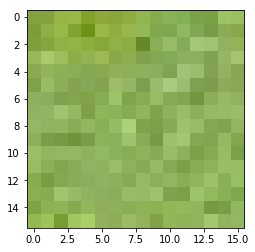

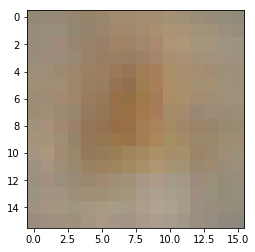

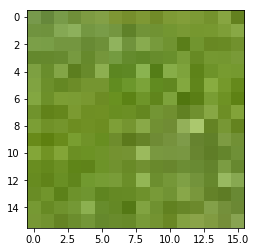

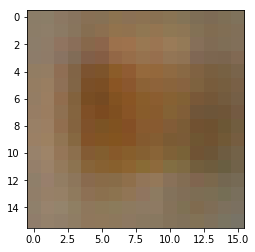

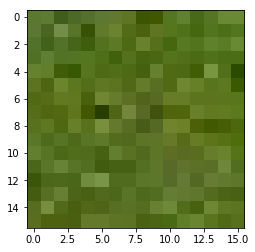

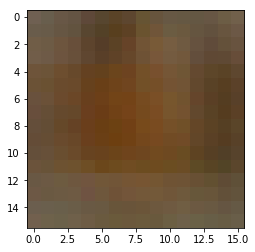

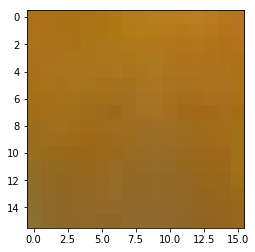

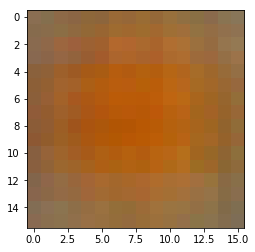

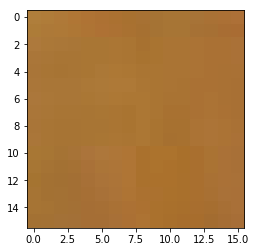

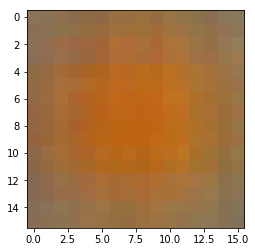

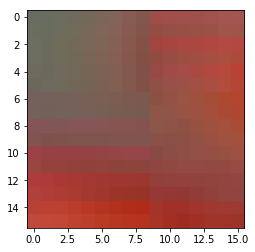

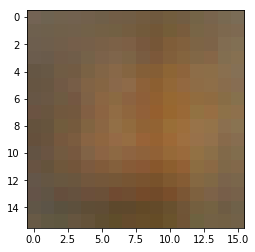

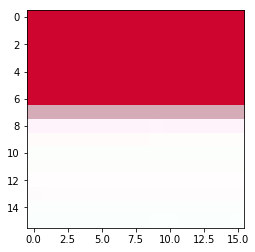

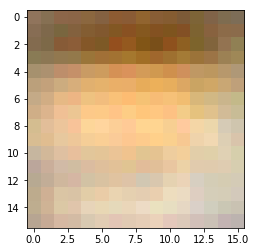

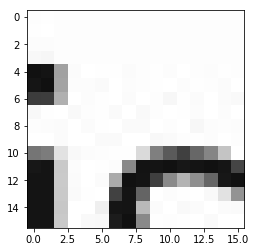

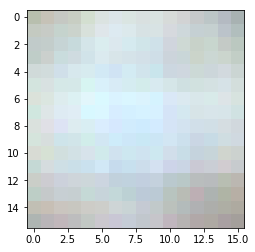

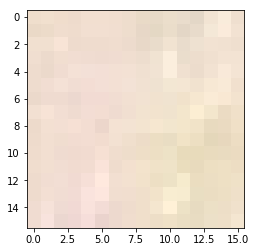

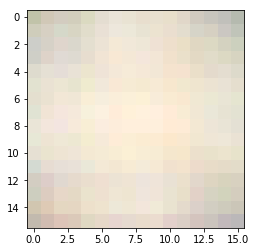

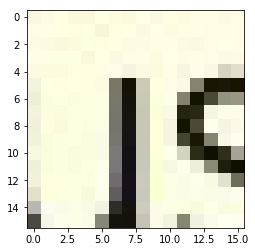

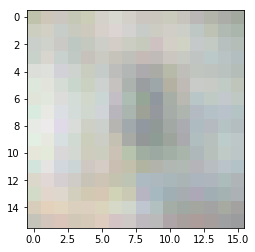

<Figure size 432x288 with 0 Axes>

In [192]:
# Plot original images and masks
count = 0;
for i in range(50,100):
    imgnum = i*100
    test_img = testDataset[0][i]
    lx = np.gradient(test_img, axis=0)
    ly = np.gradient(test_img, axis=1)
    t=np.sum(lx**2+ly**2)/(16*16)
    if t>0.01:
        test_img_show = np.transpose(test_img, axes=[1, 2, 0]) + 128/255
        plt.imshow(test_img_show)
        plt.figure()
    #Predict a new image
        pred_img = predict_img(net, test_img)
        pred_img_show = np.transpose(pred_img, axes=[1, 2, 0]) +128/255
        plt.imshow(pred_img_show)
        plt.figure()
        count= count+1
    if count == 10:
        break

torch.Size([3, 15, 15])
torch.Size([3, 15, 15])
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0118,  0.0000,  0.0000, -0.0078,
          -0.0039,  0.0000,  0.0000,  0.0000, -0.0039,  0.0000,  0.0078,
          -0.0078],
         [ 0.0039,  0.0000,  0.0039,  0.0039,  0.0078,  0.0000,  0.0000,
           0.0000, -0.0078,  0.0000,  0.0000, -0.0039, -0.0039,  0.0078,
          -0.0039],
         [-0.0039,  0.0000,  0.0078,  0.0078,  0.0078,  0.0000,  0.0000,
           0.0000,  0.0039, -0.0078,  0.0000, -0.0039, -0.0039,  0.0118,
          -0.0039],
         [ 0.0039,  0.0000,  0.0000,  0.0000,  0.0000,  0.0078,  0.0000,
           0.0039, -0.0118,  0.0000,  0.0078,  0.0078, -0.0039,  0.0078,
          -0.0039],
         [ 0.0000,  0.0039,  0.0000,  0.0000,  0.0078,  0.0039,  0.0000,
          -0.0039, -0.0039, -0.0039,  0.0078,  0.0039,  0.0000,  0.0078,
          -0.0039],
         [ 0.0039,  0.0000,  0.0039,  0.0000,  0.0039,  0.0000,  0.0039,
           0.0000, -0.0039,  0.0000,  0.0000,  0.

<Figure size 432x288 with 0 Axes>

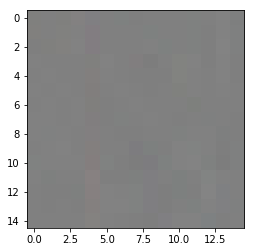

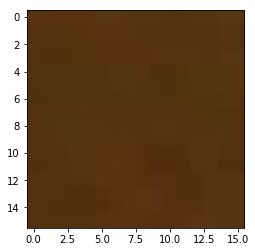

<Figure size 432x288 with 0 Axes>

In [182]:
batch_size = 50
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
for i, b in enumerate(train_loader):
    ################################################ [TODO] ###################################################
    # Get images and masks from each batch
    imgs = b['img']
    label = b['label']
    Gx_in, Gx_target, Gy_in, Gy_target= grad_loss(imgs,imgs)
    print(Gx_in.shape)
    save = imgs[49]
    if i == 1:
        break
print(Gx_in)
test_img_show = np.transpose(Gx_in, axes=[1, 2, 0]) + 128/255
plt.imshow(test_img_show)
plt.figure()       
test_img_show = np.transpose(save, axes=[1, 2, 0]) + 128/255
plt.imshow(test_img_show)
plt.figure()      

In [48]:
###ORIGINAL IMAGE

In [ ]:
val_dice = eval_net(net, val_loader)
print('Validation Dice Coeff: {}'.format(val_dice))

In [223]:
t = tf.constant([[[[1, 2, 3], [4, 5, 6]],[[1, 2, 3], [4, 5, 6]]],
                [[[1, 2, 3], [4, 5, 6]],[[1, 2, 3], [4, 5, 6]]]])
print(t.shape)
paddings = tf.constant([[0, 0,],[0, 0,],[1, 1,], [2, 2]])
p = tf.pad(t, paddings, "SYMMETRIC")
print(p.shape)
print(tf.contrib.framework.is_tensor(p))

(2, 2, 2, 3)
(2, 2, 4, 7)
True


In [42]:
a,b,c = 0.6, 0.4, 0.3


In [190]:
###Saving Parameters 3 only MSE 4 MSE + GRad loss, 5 grad loss only
PATH = './model/modelparamsGradComp4.pth'
torch.save(net, PATH)

In [191]:
# Loading parameters
PATH = './model/modelparamsGradComp4.pth'
net = torch.load(PATH)